In [1]:
# Import libraries
from pathlib import Path

import fiona
import geopandas as gpd
import h3
import pandas as pd
from h3ronpy import util, vector
from psycopg2.pool import ThreadedConnectionPool
from shapely.geometry import Polygon

In [2]:
env_path = ".env"
with open(env_path) as f:
    env = {}
    for line in f.readlines():
        if line.startswith("#"):
            continue
        env_key, _val = line.split("=", 1)
        env_value = _val.split("\n")[0]
        env[env_key] = env_value

postgres_thread_pool = ThreadedConnectionPool(
    1,
    50,
    host=env["API_POSTGRES_HOST"],
    port=env["API_POSTGRES_PORT"],
    user=env["API_POSTGRES_USERNAME"],
    password=env["API_POSTGRES_PASSWORD"],
)

In [3]:
def get_h3_for_region(
    col: str, table: str, region: str, ps_thread_pool=postgres_thread_pool
) -> pd.DataFrame:
    conn = postgres_thread_pool.getconn()
    conn.cursor()
    query = f"""
        select {col} from {table} df 
        where df.h3index in 
            (select  h3_uncompact(gr."h3Compact"::h3index[], 6) from geo_region gr 
                inner join admin_region ar 
                    on gr.id = ar."geoRegionId" 
                    and ar.name={region});
        """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df


def convert_to_geopandas(df: pd.DataFrame) -> gpd.GeoDataFrame:
    df["geometry"] = df["h3index"].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True)))
    df = gpd.GeoDataFrame(df, geometry=df.geometry)
    return df

In [4]:
def records(filename, usecols, **kwargs):
    """Generator to subset of columns from vector files"""
    with fiona.open(filename, **kwargs) as source:
        for feature in source:
            f = {k: feature[k] for k in ["id", "geometry"]}
            f["properties"] = {k: feature["properties"][k] for k in usecols}
            yield f


def vector_file_to_h3dataframe(
    filename: Path,
    columns: list,
    h3_res: int = 6,
) -> gpd.GeoDataFrame:
    """Converts a vector file to a GeoDataFrame"""
    print(f"Reading {str(filename)} and converting geometry to H3...")
    gdf = gpd.GeoDataFrame.from_features(records(filename, columns)).set_crs("EPSG:4326").explode()
    h3df = vector.geodataframe_to_h3(gdf, h3_res)
    h3df = h3df.set_index("h3index")
    return h3df

In [5]:
aqueduct_file = Path(
    "/home/biel/Vizzuality/lg_data/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg"
)

In [7]:
df = vector_file_to_h3dataframe(aqueduct_file, ["bws_cat", "bws_label"])

Reading /home/biel/Vizzuality/lg_data/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg and converting geometry to H3...


/tmp/ipykernel_1150851/841472429.py:17: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = gpd.GeoDataFrame.from_features(records(filename, columns)).set_crs("EPSG:4326").explode()


In [10]:
df.uniqu

AttributeError: 'DataFrame' object has no attribute 'unique'

In [11]:
df.groupby("bws_cat")["bws_label"].apply(lambda x: x.unique())

bws_cat
-1.0    [Arid and Low Water Use]
 0.0                [Low (<10%)]
 1.0     [Low - Medium (10-20%)]
 2.0    [Medium - High (20-40%)]
 3.0             [High (40-80%)]
 4.0     [Extremely High (>80%)]
Name: bws_label, dtype: object

## Check the duplicates in Aqueduct dataset

In [115]:
dfdf[~df.index.duplicated()]

,bws_cat,aq30_id,pfaf_id,string_id
h3index,,,,
607576025534038015,NaN,66743,-9999,None-None-3190
607576025534038015,NaN,66788,-9999,None-None-3230


In [116]:
dupes = df[df.index.duplicated()].reset_index()

In [117]:
dupe_idx = df.index[df.index.duplicated()]

In [68]:
dupes[dupes.h3index == 607576025534038015]

,h3index,bws_cat,aq30_id,pfaf_id,string_id
0,607576025534038015,NaN,66743,-9999,None-None-3190
3310,607576025534038015,NaN,66788,-9999,None-None-3230


In [18]:
gdf = util.dataframe_to_geodataframe(dupes)

In [19]:
gdf.to_file(
    "/home/biel/Vizzuality/lg_data/Y2019M07D12_Aqueduct30_V01/baseline/annual/duplicated_h3.geojson",
    driver="GeoJSON",
)

/home/biel/miniconda3/envs/landgriffon/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [20]:
# remove auqeduct h3 dataframes
del df
del gdf

### A try with h3pandas


In [5]:
buggy_df = gpd.read_file(aqueduct_file)
buggy_df = buggy_df[["bws_cat", "aq30_id", "pfaf_id", "string_id", "geometry"]]

In [6]:
buggy_h3df = buggy_df.h3.polyfill(6, explode=True)

In [7]:
buggy_h3df.head()

,bws_cat,aq30_id,pfaf_id,string_id,geometry,h3_polyfill
0,4.0,0,111011,111011-EGY.11_1-3365,"MULTIPOLYGON (((31.90591 29.85789, 31.90257 29...",NaN
1,4.0,1,111011,111011-EGY.15_1-3365,"MULTIPOLYGON (((31.90257 29.82958, 31.90591 29...",863e63d6fffffff
1,4.0,1,111011,111011-EGY.15_1-3365,"MULTIPOLYGON (((31.90257 29.82958, 31.90591 29...",863e638a7ffffff
1,4.0,1,111011,111011-EGY.15_1-3365,"MULTIPOLYGON (((31.90257 29.82958, 31.90591 29...",863e639b7ffffff
1,4.0,1,111011,111011-EGY.15_1-3365,"MULTIPOLYGON (((31.90257 29.82958, 31.90591 29...",863e63987ffffff


In [9]:
len(buggy_h3df)

3890624

In [10]:
buggy_h3df[buggy_h3df.h3_polyfill.duplicated(keep=False)].dropna(subset="h3_polyfill")

,bws_cat,aq30_id,pfaf_id,string_id,geometry,h3_polyfill
66738,NaN,66743,-9999,None-None-3190,"MULTIPOLYGON (((-169.00000 -84.71084, -168.999...",86ef0e64fffffff
66738,NaN,66743,-9999,None-None-3190,"MULTIPOLYGON (((-169.00000 -84.71084, -168.999...",86ee25c4fffffff
66738,NaN,66743,-9999,None-None-3190,"MULTIPOLYGON (((-169.00000 -84.71084, -168.999...",86ef0ac57ffffff
66738,NaN,66743,-9999,None-None-3190,"MULTIPOLYGON (((-169.00000 -84.71084, -168.999...",86ef0a2f7ffffff
66738,NaN,66743,-9999,None-None-3190,"MULTIPOLYGON (((-169.00000 -84.71084, -168.999...",86ef4d7b7ffffff
...,...,...,...,...,...,...
66861,NaN,66866,-9999,None-None-3302,"MULTIPOLYGON (((-60.22000 -80.28584, -60.31583...",86ef2b44fffffff
66861,NaN,66866,-9999,None-None-3302,"MULTIPOLYGON (((-60.22000 -80.28584, -60.31583...",86ef0d807ffffff
66861,NaN,66866,-9999,None-None-3302,"MULTIPOLYGON (((-60.22000 -80.28584, -60.31583...",86ef2b0f7ffffff
66861,NaN,66866,-9999,None-None-3302,"MULTIPOLYGON (((-60.22000 -80.28584, -60.31583...",86ef0d917ffffff


### Inpect the Antartica geometries of the original dataset

In [61]:
cols = ["bws_cat", "aq30_id", "aqid", "pfaf_id", "string_id"]
df = gpd.GeoDataFrame.from_features(records(aqueduct_file, cols)).set_crs("EPSG:4326")

In [47]:
df.head()

,geometry,bws_cat,aq30_id,aqid,pfaf_id,string_id
0,"MULTIPOLYGON (((31.90591 29.85789, 31.90257 29...",4.0,0,3365,111011,111011-EGY.11_1-3365
1,"MULTIPOLYGON (((31.90257 29.82958, 31.90591 29...",4.0,1,3365,111011,111011-EGY.15_1-3365
2,"MULTIPOLYGON (((32.36609 29.63378, 32.36160 29...",4.0,2,-9999,111011,111011-EGY.15_1-None
3,"MULTIPOLYGON (((32.46194 29.89251, 32.46440 29...",4.0,3,3365,111011,111011-None-3365
4,"MULTIPOLYGON (((32.46440 29.88856, 32.46194 29...",4.0,4,-9999,111011,111011-None-None


<AxesSubplot:>

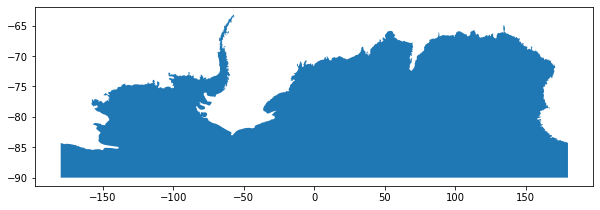

In [48]:
df.loc[df.aq30_id == 66743].plot(figsize=(10, 10))

<AxesSubplot:>

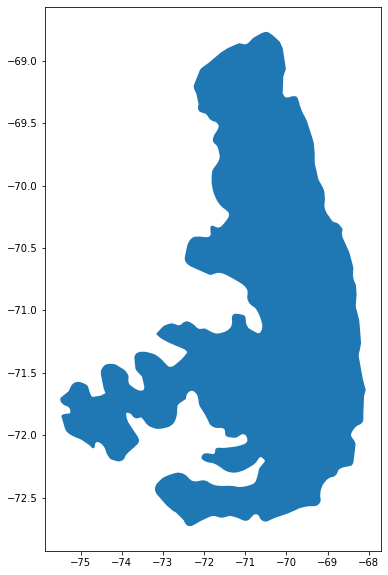

In [55]:
df.loc[df.aq30_id == 66788].plot(figsize=(10, 10))

<AxesSubplot:>

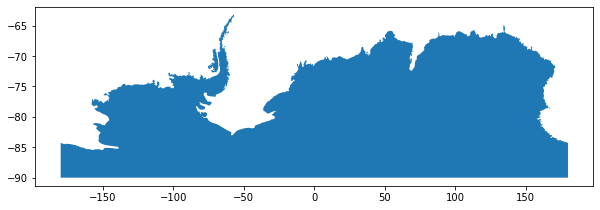

In [59]:
df.loc[df.aq30_id.isin([66788, 66743])].plot(figsize=(10, 10))

# Check H3 data ingested

In [131]:
df = get_h3_for_region(
    "bws_cat, h3index", "h3_grid_aqueduct_global", "'India'", postgres_thread_pool
)

/home/biel/miniconda3/envs/landgriffon/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [132]:
df

,bws_cat,h3index
0,4.0,86424a40fffffff
1,4.0,863dab437ffffff
2,4.0,8642e8d77ffffff
3,1.0,86608d78fffffff
4,3.0,8642c580fffffff
...,...,...
85934,3.0,8660b3747ffffff
85935,4.0,863da39afffffff
85936,4.0,8660b165fffffff
85937,4.0,86609990fffffff


In [133]:
hdf = convert_to_geopandas(df)

<AxesSubplot:>

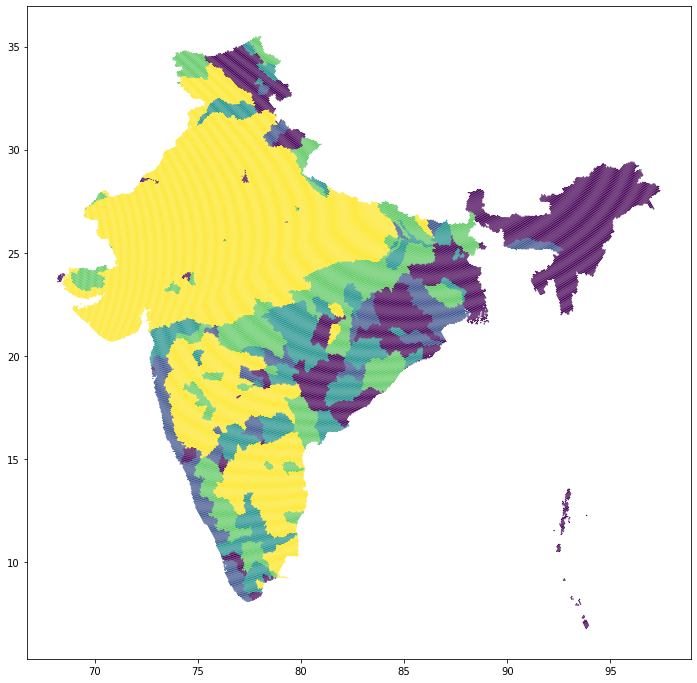

In [137]:
hdf.plot(column="bws_cat", figsize=(12, 12))

In [138]:
hdf.to_file(
    "/home/biel/Vizzuality/lg_data/Y2019M07D12_Aqueduct30_V01/baseline/annual/india_h3.geojson",
    driver="GeoJSON",
)

/home/biel/miniconda3/envs/landgriffon/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
